<a href="https://colab.research.google.com/github/denis201520182022/colorization-project/blob/main/notebooks/Train_lab_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.datasets import CIFAR10
from skimage import color
from skimage.color import lab2rgb

from google.colab import files


In [2]:


def lab_to_rgb_tensor(L_tensor, ab_tensor):
    L_np = L_tensor.squeeze(0).squeeze(0).cpu().numpy() * 100
    ab_np = ab_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0) * 128

    lab_img = np.zeros((32, 32, 3), dtype=np.float32)
    lab_img[:, :, 0] = L_np
    lab_img[:, :, 1:] = ab_np

    return lab2rgb(lab_img)

In [3]:


class CIFAR10_Lab(Dataset):
    def __init__(self, train=True):
        self.data = CIFAR10(root='./data', train=train, download=True)
        self.images = self.data.data

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_rgb = self.images[idx].astype('float32') / 255.0
        img_lab = color.rgb2lab(img_rgb)

        L = img_lab[:, :, 0] / 100.0
        ab = img_lab[:, :, 1:] / 128.0

        L_tensor = torch.tensor(L, dtype=torch.float32).unsqueeze(0)
        ab_tensor = torch.tensor(ab, dtype=torch.float32).permute(2, 0, 1)

        return L_tensor, ab_tensor


In [4]:
train_dataset = CIFAR10_Lab(train=True)
test_dataset = CIFAR10_Lab(train=False)

train_loader =DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32)

100%|██████████| 170M/170M [00:04<00:00, 41.7MB/s]


In [5]:


class SuperColorizationNet(nn.Module):
    def __init__(self):
        super(SuperColorizationNet, self).__init__()

        self.enc1 = self.conv_block(1, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(2, 2)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = self.conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = self.conv_block(128, 64)

        self.final_conv = nn.Conv2d(64, 2, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.2)
        )

    def forward(self, x):
        e1 = self.enc1(x)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        e3 = self.enc3(p2)

        d2 = self.upconv2(e3)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        out = self.final_conv(d1)
        return self.tanh(out)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

model = SuperColorizationNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

#model.load_state_dict("colorization_weights_lab_V2.pth")
#optimizer.load_state_dict('optimizer_weights_lab_V2.pth')

cuda


In [7]:
num_epochs = 10
fixed_L, fixed_ab = train_dataset[0]
fixed_L = fixed_L.unsqueeze(0).to(device)

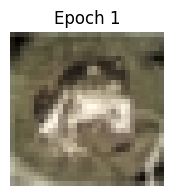

Epoch 1/10, Loss: 0.011730


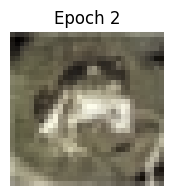

Epoch 2/10, Loss: 0.009605


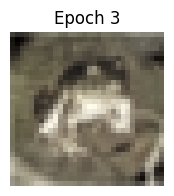

Epoch 3/10, Loss: 0.009358


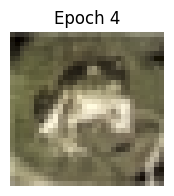

Epoch 4/10, Loss: 0.009212


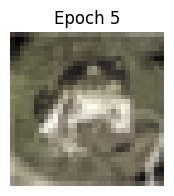

Epoch 5/10, Loss: 0.009123


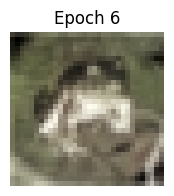

Epoch 6/10, Loss: 0.009009


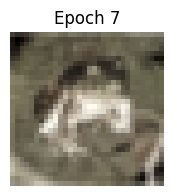

Epoch 7/10, Loss: 0.008907


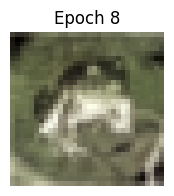

Epoch 8/10, Loss: 0.008816


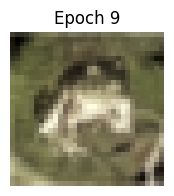

Epoch 9/10, Loss: 0.008743


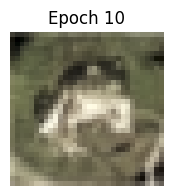

Epoch 10/10, Loss: 0.008662


In [8]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]", leave=False)

    for L, ab in loop:
        L, ab = L.to(device), ab.to(device)

        optimizer.zero_grad()
        output = model(L)
        loss = criterion(output, ab)

        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    # 6. Визуализация
    model.eval()
    with torch.no_grad():
        output_ab = model(fixed_L)

    rgb_img = lab_to_rgb_tensor(fixed_L, output_ab)

    plt.figure(figsize=(2, 2))
    plt.imshow(rgb_img)
    plt.title(f"Epoch {epoch+1}")
    plt.axis('off')
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader):.6f}")


In [9]:
torch.save(model.state_dict(), "colorization_weights_lab_V2.pth")

torch.save(optimizer.state_dict(), 'optimizer_weights_lab_V2.pth')

files.download("colorization_weights_lab_V2.pth")
files.download("optimizer_weights_lab_V2.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [10]:
model.eval()
test_loss = 0.0

with torch.no_grad():
    for L, ab in tqdm(test_loader, desc="Testing"):
        L, ab = L.to(device), ab.to(device)

        output = model(L)
        loss = criterion(output, ab)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.6f}")


Testing: 100%|██████████| 313/313 [00:05<00:00, 55.02it/s]

Test Loss: 0.008637
